In [1]:
import numpy as np
from scipy import stats, linalg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin as pg
import npeet.entropy_estimators as ee

In [20]:
def shuffle(x):
    x1 = x.copy()
    np.random.shuffle(x1)
    return x1

def fit_covariate(x, cov):
    coeffX = linalg.lstsq(cov.T, x)[0]
    return x - coeffX.dot(cov)

def partial_corr(x, y, covar):
    xFit = fit_covariate(x, covar)
    yFit = fit_covariate(y, covar)
    return np.corrcoef(xFit, yFit)[0, 1]

def make_test(nTest=100, nSample=1000, sigErr=1):
    rezDF = pd.DataFrame()

    for methodName, methodFunc in methodsDict.items():
        print(methodName)

        rezTrue = []
        rezSh = []

        for iTest in range(nTest):
            x,y,z = gen_data_red_noisy(n=nSample, sigErr=1)
            xSh = shuffle(x)
            ySh = shuffle(y)
            rezTrue += [methodFunc(x,y,z)]
            rezSh   += [methodFunc(xSh,ySh,z)]

        rezTmp = pd.DataFrame()
        rezTmp['kind'] = ['True'] * nTest + ['Sh'] * nTest
        rezTmp['Method'] = methodName
        rezTmp['Value'] = rezTrue + rezSh
        rezDF = rezDF.append(rezTmp)
    return rezDF

def plot_test(df, suptitle=None):
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    if suptitle is not None:
        fig.suptitle(suptitle)
    
    ax[0].set_title('Metric Value')
    ax[1].set_title('Effect Size')
    ax[2].set_title('Fraction Significant')
    
    sns.violinplot(ax=ax[0], x="Method", y="Value", hue="kind", data=df, scale='width')
    
    # Calculate effect sizes
    dfEffSize = pd.DataFrame()
    for method in sorted(set(df['Method'])):
        dfMethod = df[df['Method'] == method]
        dfMethodTrue = dfMethod[dfMethod['kind'] == 'True']
        dfMethodRand = dfMethod[dfMethod['kind'] == 'Sh']
        
        muRand = np.mean(dfMethodRand['Value'])
        stdRand = np.std(dfMethodRand['Value'])
        
        dfMethodEff = dfMethodTrue.copy()
        dfMethodEff['Value'] = (dfMethodEff['Value'] - muRand) / stdRand
        
        dfEffSize = dfEffSize.append(dfMethodEff)
        
    sns.violinplot(ax=ax[1], x="Method", y="Value", data=dfEffSize, scale='width')
    #ax[1].axhline(y='2', color='pink', linestyle='--')
    
    # Calculate fraction significant
    sigDict = {}
    for method in sorted(set(df['Method'])):
        dfEffMethod = dfEffSize[dfEffSize['Method'] == method]
        sigDict[method] = [np.mean(dfEffMethod['Value'] > 2)]
    
    sns.barplot(ax=ax[2], data=pd.DataFrame(sigDict))

In [3]:
methodsDict = {
    'corr'    : lambda x,y,z: np.corrcoef(x,y)[0,1],
    'pcorr'   : lambda x,y,z: partial_corr(x, y, np.array([z])),
    'mi'      : lambda x,y,z: ee.mi(x, y),
    'cmi'     : lambda x,y,z: ee.cmi(x, y, z)
}

## Noisy Redundant Scenario
### Test significance vs shuffe for fixed parameters

In [44]:
def gen_data_red_noisy(n=1000, sigRed=1, sigErr=1, sigErrZ=1):
    t = np.random.normal(0,sigRed,n)
    x = t + np.random.normal(0,sigErr,n)
    y = t + np.random.normal(0,sigErr,n)
    z = t + np.random.normal(0,sigErrZ,n)
    return x,y,z

In [10]:
rezDF = make_test(nTest=100, nSample=10000, sigErr=1)

corr
pcorr
mi
cmi


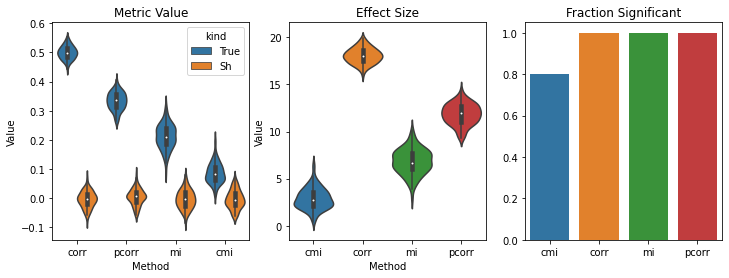

In [11]:
plot_test(rezDF)

### Test asymptotic convergence

In [31]:
def test_convergence(nSampleLst, nTest):
    valDict = {k: [] for k in methodsDict.keys()}
    effDict = {k: [] for k in methodsDict.keys()}
    
    for nSample in nSampleLst:
        print(nSample)
        
        for methodName, methodFunc in methodsDict.items():
            x,y,z = gen_data_red_noisy(n=nSample, sigErr=1)

            rezTrue = methodFunc(x, y, z)

            rezShLst = [methodFunc(x, shuffle(y), z) for iTest in range(nTest)]
            
            effSize = (rezTrue - np.mean(rezShLst)) / np.std(rezShLst)
            
            valDict[methodName] += [rezTrue]
            effDict[methodName] += [effSize]
            
    return valDict, effDict

In [32]:
nSampleLst = (10**np.linspace(2, 5, 10)).astype(int)
valDict, effDict = test_convergence(nSampleLst, 1000)

100
215
464
1000
2154
4641
10000
21544
46415
100000


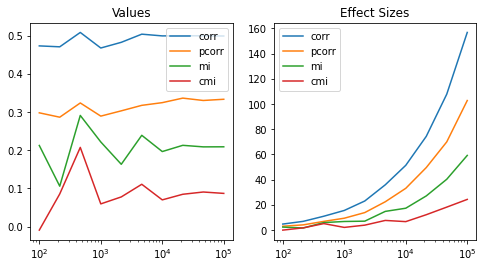

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
for methodName in methodsDict.keys():
    ax[0].semilogx(nSampleLst, valDict[methodName], label=methodName)
    ax[1].semilogx(nSampleLst, effDict[methodName], label=methodName)

ax[0].set_title('Values')
ax[1].set_title('Effect Sizes')
ax[0].legend()
ax[1].legend()
plt.show()

### Test Based on Noise-To-Signal Ratio

In [45]:
def test_noise_effect(sigErrLst, nTest, nSample):
    valDict = {k: [] for k in methodsDict.keys()}
    effDict = {k: [] for k in methodsDict.keys()}
    
    for sigErr in sigErrLst:
        print(sigErr)
        
        for methodName, methodFunc in methodsDict.items():
            x,y,z = gen_data_red_noisy(n=nSample, sigErrZ=sigErr)

            rezTrue = methodFunc(x, y, z)

            rezShLst = [methodFunc(x, shuffle(y), z) for iTest in range(nTest)]
            
            effSize = (rezTrue - np.mean(rezShLst)) / np.std(rezShLst)
            
            valDict[methodName] += [rezTrue]
            effDict[methodName] += [effSize]
            
    return valDict, effDict

In [46]:
sigErrLst = np.linspace(0, 1, 10)
valDict, effDict = test_noise_effect(sigErrLst, 1000, 1000)

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


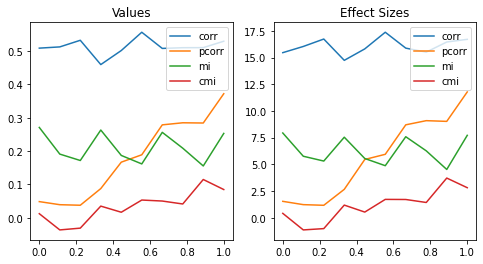

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
for methodName in methodsDict.keys():
    ax[0].plot(sigErrLst, valDict[methodName], label=methodName)
    ax[1].plot(sigErrLst, effDict[methodName], label=methodName)

ax[0].set_title('Values')
ax[1].set_title('Effect Sizes')
ax[0].legend()
ax[1].legend()
plt.show()